In [1]:
import pandas as pd
import re

# Load .txt files using correct semicolon separator
def load_txt(file_path):
    return pd.read_csv(file_path, sep=";", names=["text", "label"])

train_df = load_txt("train.txt")
test_df = load_txt("test.txt")
val_df = load_txt("val.txt")

# Check loaded data
print(train_df.head())
print(train_df['label'].value_counts())


                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove special chars
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

train_df["text"] = train_df["text"].apply(clean_text)
test_df["text"] = test_df["text"].apply(clean_text)
val_df["text"] = val_df["text"].apply(clean_text)


In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["emotion"] = le.fit_transform(train_df["label"])
test_df["emotion"] = le.transform(test_df["label"])
val_df["emotion"] = le.transform(val_df["label"])  # optional


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)

X_train = tfidf.fit_transform(train_df["text"])
X_test = tfidf.transform(test_df["text"])

y_train = train_df["emotion"]
y_test = test_df["emotion"]


In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [6]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

y_pred = model.predict(X_test)

print("✅ Accuracy :", round(accuracy_score(y_test, y_pred), 2))
print("✅ Precision:", round(precision_score(y_test, y_pred, average="weighted"), 2))
print("✅ Recall   :", round(recall_score(y_test, y_pred, average="weighted"), 2))
print("✅ F1 Score :", round(f1_score(y_test, y_pred, average="weighted"), 2))
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


✅ Accuracy : 0.87
✅ Precision: 0.87
✅ Recall   : 0.87
✅ F1 Score : 0.86

📋 Classification Report:

              precision    recall  f1-score   support

       anger       0.90      0.82      0.86       275
        fear       0.89      0.79      0.84       224
         joy       0.84      0.96      0.89       695
        love       0.82      0.59      0.69       159
     sadness       0.90      0.93      0.91       581
    surprise       0.85      0.52      0.64        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.81      2000
weighted avg       0.87      0.87      0.86      2000



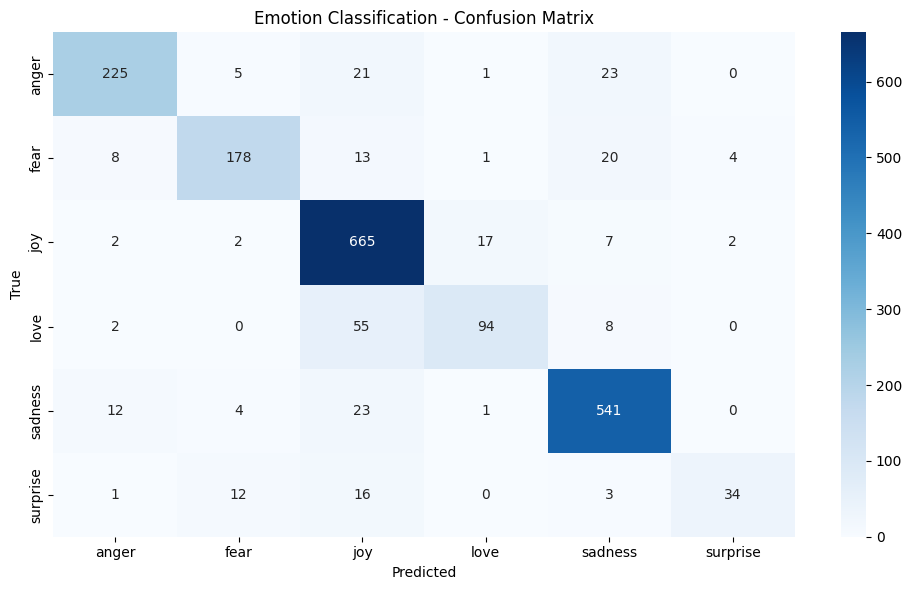

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Emotion Classification - Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_emotion.png")
plt.show()


In [8]:
import pickle

pickle.dump(model, open("emotion_model.pkl", "wb"))
pickle.dump(tfidf, open("emotion_vectorizer.pkl", "wb"))
pickle.dump(le, open("emotion_label_encoder.pkl", "wb"))
